# Fama French Five Factor Model

In [1]:
import vectorbt as vbt
import pandas as pd
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import getFamaFrenchFactors as fff
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# Create the data

In [5]:
# list low volume stocks
# https://finviz.com/screener.ashx?v=111&f=exch_nasd,geo_usa,ipodate_more15&o=volume
# if we were doing more, I would set up API, but this is only 10 stocks

# stocks_list = ['SPY', 'INTG', 'HFBL', 'SFBC', 'AIRT', 'EEA', 'CSD', 'GBLI', 'NXN', 'PFIN', 'LINK']
# securities = vbt.YFData.download(symbols=stocks_list)
# sectors = securities.data.keys()
# # create a new column for each sector
# df = pd.DataFrame()
# for sector in sectors:
#   df[sector] = securities.data[sector]['Close']
# # make index tz-naive
# df.index = df.index.tz_localize(None)
# df = df.dropna()

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/data/base.py:527: UserWarning: Symbols have mismatching index. Setting missing data points to NaN.
  data = cls.align_index(data, missing=missing_index)


In [ ]:
df = pd.DataFrame(vbt.YFData.download(symbols=['INTG']).data['INTG']['Close'])
df.index = df.index.tz_localize(None)
df = df.dropna()
df.rename(columns={'Close': 'INTG'}, inplace=True)

In [ ]:
def calc_er(df, ticker, alpha=0.9):
    df = df.copy()
    # get factors and merge stock returns with factors
    ff3_monthly = fff.famaFrench3Factor(frequency='m')
    ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
    ff3_monthly.set_index('Date', inplace=True)
    ff3_monthly = ff3_monthly[ff3_monthly.index >= '2008-01-09 05:00:00']
    # get monthly stock returns so we have continuous data with factors
    stock_returns = df[ticker].resample('M').last().pct_change().dropna()
    stock_returns = stock_returns.rename('monthly_returns')
    df = df[df.index >= '2008-01-09 05:00:00']
    # join stock_returns, df, and factors
    df = pd.merge_asof(df.sort_values('Date'), stock_returns, left_on='Date', right_on='Date')
    df = pd.merge_asof(df.sort_values('Date'), ff3_monthly, left_on='Date', right_on='Date')
    # fill in factors since data is monthly but we want daily
    df['size_premium'] = df['SMB'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill()
    df['value_premium'] = df['HML'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill()
    df['risk_prem'] = df['Mkt-RF'].fillna(df['Mkt-RF'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill())
    df['risk-free'] = df['RF'].fillna(df['RF'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill())
    df['y'] = df['monthly_returns'].fillna(df['monthly_returns'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill())
    return df

# ticker_models = {}
# for ticker in df.columns:
#     ticker_models[ticker] = df

intg = calc_er(df, 'INTG')

In [ ]:
# Add sentiment factor
sentiment_idx = pd.read_csv('data/sentiment_idx.csv')
sentiment_idx['date'] = pd.to_datetime(sentiment_idx['date'])
intg = pd.merge_asof(intg, sentiment_idx, left_on='Date', right_on='date')

# Run Regression

In [102]:
def get_coefs(df, ticker):
  y = df['y']
  X = df[['size_premium', 'value_premium', 'risk_prem', 'risk-free']]
  poly = PolynomialFeatures(degree=3, include_bias=False)
  X_poly = poly.fit_transform(X)
  X = sm.add_constant(X_poly)
  # get all x rows with no null values
  ff_model = sm.OLS(y, X).fit()
  print(ff_model.summary())
  predicted_y = ff_model.predict(X)
  # update the expected returns column with the latest prediction
  df[f'{ticker}_er'] = predicted_y / 30
  return (df, ff_model)
preds = get_coefs(intg, 'INTG')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     33.01
Date:                Thu, 11 May 2023   Prob (F-statistic):          1.54e-185
Time:                        00:49:37   Log-Likelihood:                 4317.5
No. Observations:                3861   AIC:                            -8565.
Df Residuals:                    3826   BIC:                            -8346.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0112      0.003      3.858      0.0

In [103]:
from datetime import timedelta

def test_train_split(df):
  # Determine the date range for the test dataset (most recent data point - 3 years)
  test_end_date = df.iloc[-1]['date']
  test_start_date = min(test_end_date - timedelta(days=3*365), df.iloc[round(len(df) * 0.8)]['date'])

  # Split the data into train and test datasets
  train_data = df[df['date'] < test_start_date]
  test_data = df[df['date'] >= test_start_date]
  return (test_data, train_data)

def get_coefs_train_test(df, ticker, degree=1):
  # Split data into training and testing sets
  train_df, test_df = test_train_split(df)
  y_train = train_df['y']
  X_train = train_df[['size_premium', 'value_premium', 'risk_prem', 'risk-free', 'sentiment']]
  poly = PolynomialFeatures(degree=degree, include_bias=True)
  X_train = poly.fit_transform(X_train)
  
  # fit model on training data
  ff_model = sm.OLS(y_train, X_train).fit()
  print(ff_model.summary())
  
  # predict y values for testing data
  X_test = test_df[['size_premium', 'value_premium', 'risk_prem', 'risk-free', 'sentiment']]
  X_test = poly.fit_transform(X_test)
  predicted_y = ff_model.predict(X_test)
  
  # update the expected returns column with the latest prediction for testing data
  test_df[f'{ticker}_er'] = predicted_y * 3
  
  r2_score(test_preds['monthly_returns'], test_preds['INTG_er'])

  return (train_df, test_df, ff_model)
  
train_preds, test_preds, model = get_coefs_train_test(intg, 'INTG', degree=2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     36.40
Date:                Thu, 11 May 2023   Prob (F-statistic):           8.52e-98
Time:                        00:49:37   Log-Likelihood:                 1085.4
No. Observations:                 812   AIC:                            -2129.
Df Residuals:                     791   BIC:                            -2030.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.006      4.735      0.0

/var/folders/pw/wpnw6hs16b35mpds4px4ghs00000gn/T/ipykernel_77041/3588241371.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'{ticker}_er'] = predicted_y * 3


In [108]:
def test_train_split(df):
    # Determine the date range for the test dataset (most recent data point - 3 years)
    test_end_date = df.iloc[-1]['date']
    test_start_date = min(test_end_date - timedelta(days=3*365), df.iloc[round(len(df) * 0.8)]['date'])

    # Split the data into train and test datasets
    train_data = df[df['date'] < test_start_date]
    test_data = df[df['date'] >= test_start_date]
    return (test_data, train_data)

def get_coefs_train_test(df, ticker, degree=1):
    # Split data into training and testing sets
    train_df, test_df = test_train_split(df)
    y_train = train_df['y']
    X_train = train_df[['size_premium', 'value_premium', 'risk_prem', 'risk-free']]
    
    # Perform polynomial regression on the specified factors (without 'sentiment')
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    # poly = make_pipeline(PolynomialFeatures(degree=degree, include_bias=True), Lasso(alpha=0.1))
    X_train_poly1 = poly.fit_transform(X_train)
    linear_model = Lasso(alpha=0.00001)
    print(X_train_poly1.shape)
    ff_model1 = linear_model.fit(y=y_train, X=X_train_poly1)
    
    # Calculate the residuals from the first regression
    residuals = y_train - ff_model1.predict(X_train_poly1)
    
    # Perform polynomial regression of the same degree using the residuals and the 'sentiment' column
    X_train_sentiment = train_df[['sentiment']]
    linear_model = Lasso(alpha=0.00001)
    X_train_poly2 = poly.fit_transform(X_train_sentiment)
    ff_model2 = linear_model.fit(y=residuals, X=X_train_poly2)
    
    # Combine the coefficients from both models as if they are in one equation
    print(ff_model1.coef_.shape)
    print(ff_model2.coef_.shape)
    # combined_coefs = np.hstack((ff_model1.coef_, ff_model2.coef_))
    
    # Predict y values for testing data
    X_test = test_df[['size_premium', 'value_premium', 'risk_prem', 'risk-free']]
    X_test_poly1 = poly.fit_transform(X_test)
    y_test_predicted1 = ff_model1.predict(X_test_poly1)
    
    X_test_sentiment = test_df[['sentiment']]
    X_test_poly2 = poly.fit_transform(X_test_sentiment)
    y_test_predicted2 = ff_model2.predict(X_test_poly2)

    # Combine the predictions from both models
    predicted_y = y_test_predicted1 + y_test_predicted2
    
    # Update the expected returns column with the latest prediction for testing data
    test_df[f'{ticker}_er'] = predicted_y * 3
    
    return (train_df, test_df, combined_coefs)

train_preds, test_preds, combined_coefs = get_coefs_train_test(intg, 'INTG', degree=2)

(812, 15)
(15,)
(3,)


/var/folders/pw/wpnw6hs16b35mpds4px4ghs00000gn/T/ipykernel_77041/28746333.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'{ticker}_er'] = predicted_y * 3


# Evaluate

<AxesSubplot: xlabel='Date'>

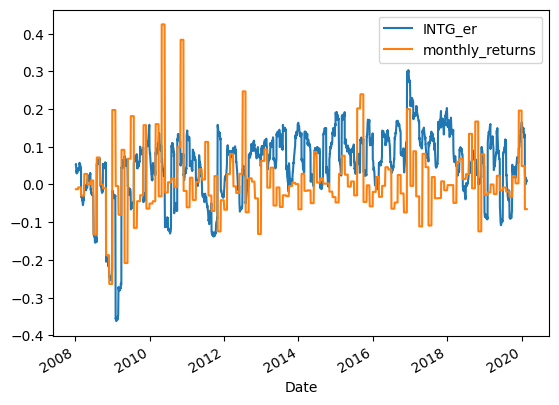

In [109]:
test_preds.plot('Date',['INTG_er', 'monthly_returns'], kind='line')

In [110]:
r2_score(test_preds['monthly_returns'], test_preds['INTG_er'])
test_preds[['monthly_returns', 'INTG_er']].corr()

,monthly_returns,INTG_er
monthly_returns,1.000000,0.178902
INTG_er,0.178902,1.000000


<AxesSubplot: xlabel='Date'>

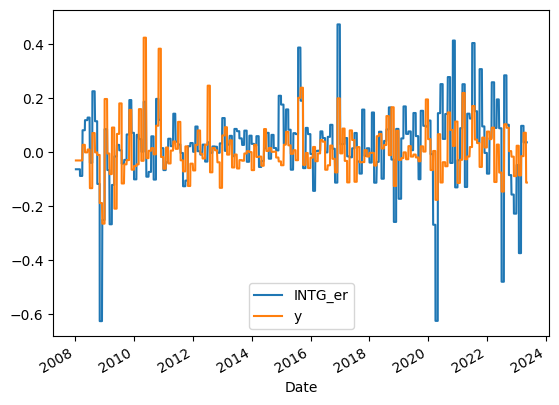

In [16]:
preds['INTG_er'] /= 3
preds.plot('Date', ['INTG_er', 'y'], kind='line')